In [1]:
#make transformations valid for rectangles and Ls
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim

import numpy as np
np.random.seed(42)

import pickle
from sklearn.model_selection import train_test_split


from make_analogies_functions import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_samples = 100000 #each sample is a trio of images of which each comes in various forms (analogous transformations).
img_size = 10
pairs_per_task = 3
shape = "rectangle" #rectangle or L
all_images = []
method_names = ["Grown", "Moved", "Rotated", "Inverted", "Mirrored", "Close/Far Corners", "Close/Far Edges", "Stretched", "Shadows", "Gravity", "Count"]
seed_iteration = 0
data = []

In [ ]:
np.random.seed(22)
im = create_image(10, shape="rectangle")
print(im)
count_pixels(im, True, True)

In [2]:
#make data
for i in range(num_samples):    
    trios = []
    invalid_img = True
    while invalid_img:
        seed_iteration += 1
        np.random.seed(seed_iteration)

        #make 3 random images with rectangles
        trio = [create_image(img_size = img_size, shape = shape) for _ in range(pairs_per_task)]

        #sample parameters for analogies
        mirror_horizontal = np.random.choice([True, False])
        rotation_degree = np.random.choice([90, 180, 270])
        grow_left = np.random.choice([0,0,1,2])
        grow_right = np.random.choice([0,0,1,2])
        grow_top = np.random.choice([0,0,1,2])
        grow_bottom = np.random.choice([0,0,1,2])
        move_vertical = np.random.choice([-2,-1,0,1,2])
        move_horizontal = np.random.choice([-2,-1,0,1,2])
        furthest_edge = np.random.choice([True, False])
        furthest_corner = np.random.choice([True, False])
        reverse_shadows = np.random.choice([True, False])
        gravity_direction = np.random.choice(["up","down","left","right"])
        count_left_right = np.random.choice([True, False])
        count_top_bottom = np.random.choice([True, False])

        # Generate analogies
        growths = [grow(img, grow_top, grow_bottom, grow_left, grow_right) for img in trio]
        moves = [move(img, move_horizontal, move_vertical)  for img in trio]
        rotations = [rotate_image(img, rotation_degree) for img in trio]
        inversions = [invert_colors(img)  for img in trio]
        mirrors = [mirror_image(img, horizontal=mirror_horizontal) for img in trio]
        corner_cells = [paint_corner(img, furthest_corner) for img in trio]
        edges = [paint_edge(img, furthest_edge) for img in trio]
        stretches = [stretch_rectangle(img) for img in trio]
        shadows = [draw_shadows(img, reverse_shadows)  for img in trio]
        gravities = [gravity(img, gravity_direction)  for img in trio]
        counts = [count_pixels(img, count_left_right, count_top_bottom) for img in trio]
        
        #check whether images violate rules (original three include duplicates; initial transformations left the canvas)
        if np.array_equal(trio[0], trio[1]) or np.array_equal(trio[0], trio[2]) or np.array_equal(trio[1], trio[2]):
            invalid_img = True
        elif invalid_matrix(growths[0], img_size, img_size, 1):
            invalid_img = True
        elif invalid_matrix(growths[0], img_size, img_size, 1):
            invalid_img = True
        else:
            invalid_img = False
    
    transformed_trios = [growths, moves, rotations, inversions, mirrors, corner_cells, edges, stretches, shadows, gravities, counts]
    data.append([np.stack([trio, transformed_trio]) for transformed_trio in transformed_trios])

data = np.array(data)

long_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2], data.shape[3], data.shape[4], data.shape[5])
long_data = long_data.reshape(long_data.shape[0], long_data.shape[1] * long_data.shape[2], long_data.shape[3], long_data.shape[4])
nonduplicates = np.unique(long_data, axis=0) #get rid of duplicated tasks; could be stricter by also considering flipped fewshot orders as duplicated
print(f"{np.round(100*(1 - nonduplicates.shape[0] / long_data.shape[0]),1)}% double trios were duplicated") 
print(long_data.shape)

0.1% double trios were duplicated
(1100000, 6, 10, 10)


In [3]:
with open(f"nonduplicates_{shape}.pkl", "wb") as f:
    pickle.dump(nonduplicates, file=f)

# with open(f"nonduplicates_{shape}.pkl", "rb") as f:
#     nonduplicates = pickle.load(file=f)

In [ ]:
for i in range(0, 2):
    plot_double_trio(nonduplicates[i])

In [10]:
# Split into input (x) and output (y)
x_data = nonduplicates[:, :-1, :, :] / 255 # All but the last channel
y_data = nonduplicates[:, -1, :, :] / 255  # Only the last channel

# Convert to PyTorch tensors
x_data = torch.from_numpy(x_data).float()
y_data = torch.from_numpy(y_data).float()

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.005, random_state=42)

# Print the shapes of the resulting tensors
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

batch_size = 512  # You can adjust the batch size as needed
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_train shape: torch.Size([1093736, 5, 10, 10])
y_train shape: torch.Size([1093736, 10, 10])
x_test shape: torch.Size([5497, 5, 10, 10])
y_test shape: torch.Size([5497, 10, 10])


In [6]:
#basic feed forward test
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(5 * 10 * 10, 200) 
        self.relu1 = nn.ReLU()  
        self.fc2 = nn.Linear(200, 200) 
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(200, 200) 
        self.relu3 = nn.ReLU() 
        self.fc4 = nn.Linear(200, 10 * 10) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x.view(-1, 10, 10)

In [13]:
num_epochs = 100
learning_rate = 0.001

# Create an instance of the model
model = FullyConnectedNN().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs, verbose=True)

for epoch in range(num_epochs):
    for (inputs, labels) in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model.train()
        optimizer.zero_grad()
        train_outputs = model(inputs)
        loss = criterion(train_outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test: {test_loss.item():.4f}')

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Nr params: {pytorch_total_params}")
torch.save(model.state_dict(), f'model_trained_on_{shape}.pth')

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9100e-04.
Epoch [1/100], Loss: 0.1102, Test: 0.1060
Adjusting learning rate of group 0 to 9.8200e-04.
Epoch [2/100], Loss: 0.0729, Test: 0.0745
Adjusting learning rate of group 0 to 9.7300e-04.
Epoch [3/100], Loss: 0.0525, Test: 0.0557
Adjusting learning rate of group 0 to 9.6400e-04.
Epoch [4/100], Loss: 0.0404, Test: 0.0448
Adjusting learning rate of group 0 to 9.5500e-04.
Epoch [5/100], Loss: 0.0410, Test: 0.0384
Adjusting learning rate of group 0 to 9.4600e-04.
Epoch [6/100], Loss: 0.0354, Test: 0.0341
Adjusting learning rate of group 0 to 9.3700e-04.
Epoch [7/100], Loss: 0.0306, Test: 0.0308
Adjusting learning rate of group 0 to 9.2800e-04.
Epoch [8/100], Loss: 0.0378, Test: 0.0285
Adjusting learning rate of group 0 to 9.1900e-04.
Epoch [9/100], Loss: 0.0278, Test: 0.0270
Adjusting learning rate of group 0 to 9.1000e-04.
Epoch [10/100], Loss: 0.0217, Test: 0.0250
Adjusting learning rate of gr

In [8]:
model = FullyConnectedNN()
model.load_state_dict(torch.load(f'model_trained_on_{shape}.pth'))

<All keys matched successfully>

Test set example:


<Figure size 1200x400 with 0 Axes>

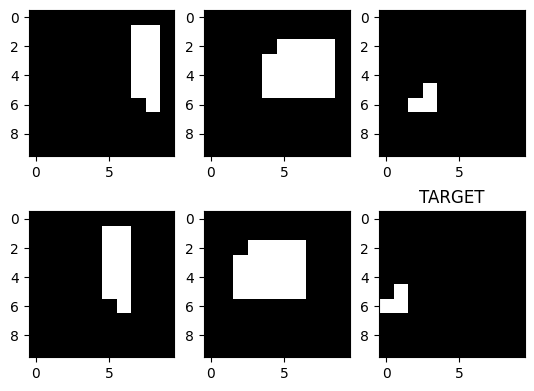

Prediction:


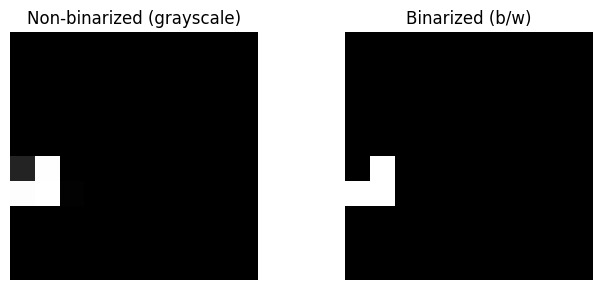

Most similar training case:


<Figure size 1200x400 with 0 Axes>

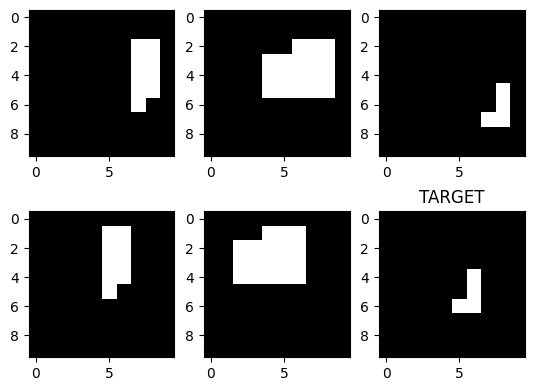

In [33]:
plot_exmp = 2
with torch.no_grad():
    print("Test set example:")
    y  = y_test[plot_exmp].expand(1, y_test[plot_exmp].shape[0], y_test[plot_exmp].shape[1])
    example = torch.row_stack((x_test[plot_exmp], y))
    plot_double_trio(example)

    print("Prediction:")
    tensor = model(x_test[plot_exmp].unsqueeze(0))[0]
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns
    axs[0].set_title("Non-binarized (grayscale)")
    axs[0].imshow(tensor, cmap='gray')
    axs[0].axis('off')
    axs[1].set_title("Binarized (b/w)")
    axs[1].imshow(torch.round(tensor), cmap='gray')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Most similar training case:")
    distances = [torch.sum(torch.abs(x_test[plot_exmp] - np.array(x_train[i]))).item() for i in range(x_train.shape[0])]
    sim_index = np.argmin(distances)
    y  = y_train[sim_index].expand(1, y_train[sim_index].shape[0], y_train[sim_index].shape[1])
    plot_double_trio(torch.row_stack((x_train[sim_index], y)))

In [4]:
#predict on other datafile (e.g. differently shaped figures)
test_shape = "rectangle"

with open(f"nonduplicates_{test_shape}.pkl", "rb") as f:
    added_test_data = pickle.load(file=f)

added_x_data = added_test_data[:, :-1, :, :] / 255 # All but the last channel
added_y_data = added_test_data[:, -1, :, :] / 255  # Only the last channel

# Convert to PyTorch tensors
added_x_data = torch.from_numpy(added_x_data).float()
added_y_data = torch.from_numpy(added_y_data).float()

Example from additional dataset:


<Figure size 1200x400 with 0 Axes>

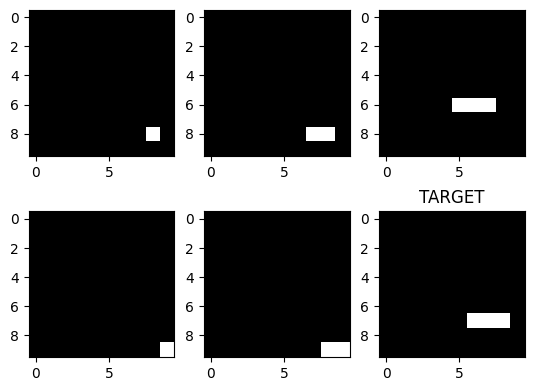

Prediction:


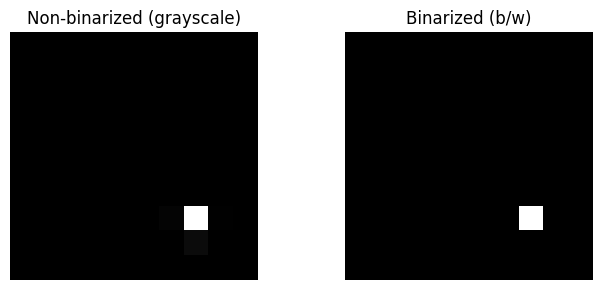

In [14]:
#predict on other datafile (e.g. differently shaped figures)
plot_exmp = 33
with torch.no_grad():
    print("Example from additional dataset:")
    added_y  = added_y_data[plot_exmp].expand(1, added_y_data[plot_exmp].shape[0], added_y_data[plot_exmp].shape[1])
    example = torch.row_stack((added_x_data[plot_exmp], added_y))
    plot_double_trio(example)

    print("Prediction:")
    tensor = model(added_x_data[plot_exmp].unsqueeze(0))[0]
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns
    axs[0].set_title("Non-binarized (grayscale)")
    axs[0].imshow(tensor, cmap='gray')
    axs[0].axis('off')
    axs[1].set_title("Binarized (b/w)")
    axs[1].imshow(torch.round(tensor), cmap='gray')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()